<img src="https://raw.githubusercontent.com/thinkingmachines/project-cchain/gh-pages/assets/full_logo.png" alt="drawing" width="400"/>

# Using the linked dataset in a baseline model for predicting disease outbreak periods

This notebook demonstrates the use of the linked dataset in creating a baseline machine learning model for predicting disease outbreaks.

Run **one code block at a time, in order,** to successfully run this model



## **SCENARIO: Weekly city-level dengue outbreak prediction for Zamboanga City**

The following are the model parameters required by the scenario:

| Specifications     |                |
|--------------------|----------------|
| Location           | Zamboanga City |
| Disease to predict | Dengue         |
| Years covered      | 2014-2020      |
| Model              | Random Forest  |

Before running this notebook, make sure to have created a linked dataset using the [linking notebook](). Select the following datasets and columns to include the following as environmental factors:

| Factor            | Variables                                                                              |
|-------------------|----------------------------------------------------------------------------------------|
| Climate           | temperature, humidity, rainfall, solar radiation, wind speed |
| Demographics      | population, population density                                                         |
| Facilities        | clinics, hospitals,                                           |
| Economic activity | nightlights radiance                                                                   |

For this demo, we define a disease outbreak as follows:

1. The **start** of an outbreak occurs when the week's cases are equal to or higher than a threshold.

    - The **threshold** is defined as the *75th percentile* of total weekly cases based on *years when a substantial number of cases* are recorded.

2. The **end** of an outbreak occurs during the week when cases fall below the threshold for *at least 2 weeks*.

Lastly, we will use the following split for training and testing:

| Data split    |                |
|--------------------|----------------|
| Training           | Jan 2014-Mar 2019 (6 years and 3 months) |
| Testing            | Apr 2019- Dec 2020 (1 year and 8 months)        |


## 1. Setting Up

Before running the cells below, please do the following:
1. Create a folder at your preferred location in your Google Drive
2. Enter the folder and create the following folders inside
  *   `data/`
  *   `code/`

2. Download all files from [here](https://drive.google.com/drive/folders/1VaUIEkjZ7SJCOoy4_nXE80Mx8S5ksVFZ?usp=drive_link). Upload all .csv files to `data/`

3. Download this notebook file and upload to `code/`

In [ ]:
# @title 1.1. Install necessary packages
# @markdown Disregard the messages seen during installation.
# @markdown These won't cause a problem in the succeeding sections.

!pip -q install sklearn
!pip -q install shap
!pip -q install matplotlib
!pip -q install plotly
!pip -q install shapash


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 651.7/651.7 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 44.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.5/222.5 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 642.7/642.7 kB 41.3 MB/s eta 0:00:00
  Preparing metadata 

In [ ]:
# @title 1.2. Load Packages
# @markdown Do not skip this step to be able to run the model experiment and the visualizations.
from pathlib import Path

import os
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
)
import shap
from shapash import SmartExplainer

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import plotly.graph_objects as go
import plotly.express as px

# widgets
import ipywidgets as widgets
from IPython.display import display
from IPython.display import Javascript

# google work environment
from google.colab import auth
from google.colab import drive
from google.colab import files

# mount google drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# @title 1.3. Select generated linked dataset path
# @markdown DO NOT SKIP RUNNING THIS BLOCK. This section sets the location of the input dataset.
print ("Sample input file: /content/gdrive/Shareddrives/[EXT] Lacuna Fund - Shared Drive/Project CCHAIN/processed/city_merged.csv")

####### INPUT FOLDER DIRECTORY WIDGET ########
input_directory  = widgets.Text(
    placeholder='Type input folder here and press ENTER',
    description='Input folder:',
    disabled=False,
    layout={'width': '95%'}
)
def handle_input_directory_folder_enter(sender):
  assert sender, "Please enter a non-empty string."
  print(f'Checking directory: {sender.value.strip()}')
  assert os.path.exists(sender.value.strip()), f"ERROR: Directory does not exist.\nPlease enter a valid directory before proceeding with next cell."
  input_folder = sender.value.strip()
  print("Directory exists! Please proceed with the next code cell.")
input_directory.on_submit(handle_input_directory_folder_enter)
display(input_directory)


Sample input file: /content/gdrive/Shareddrives/[EXT] Lacuna Fund - Shared Drive/Project CCHAIN/processed/city_merged.csv


Text(value='', description='Input folder:', layout=Layout(width='95%'), placeholder='Type input folder here an…

Checking directory: /content/gdrive/Shareddrives/[EXT] Lacuna Fund - Shared Drive/Project CCHAIN/processed/city_merged.csv
Directory exists! Please proceed with the next code cell.


## 2. Load the dataset

### 2.1. Read the dataset from provided path

In [ ]:
linked_data_path = input_directory.value
linked_data = pd.read_csv(linked_data_path)
linked_data.head()

,adm3_en,adm3_pcode,date,year,week,avg_rad_mean,clinic_count,clinic_nearest,dentist_count,dentist_nearest,...,pop_count_total,pr,rh,solar_rad,tave,tmax,tmin,uv_rad,wind_speed,case_total_dengue
0,Zamboanga City,PH097332000,2014-01-06,2014,1,0.476876,0.0,10000.0,0.0,10000.0,...,780762.749132,6.797299,82.725024,164.324125,26.074474,27.189105,25.145137,20.508032,3.735253,48.0
1,Zamboanga City,PH097332000,2014-01-13,2014,2,0.476876,0.0,10000.0,0.0,10000.0,...,780762.749132,4.642233,82.548584,171.025991,25.301183,26.346243,24.495746,21.555577,5.431501,71.0
2,Zamboanga City,PH097332000,2014-01-20,2014,3,0.476876,0.0,10000.0,0.0,10000.0,...,780762.749132,0.888642,78.586318,216.642606,25.210041,26.767400,24.052373,26.568703,4.394535,82.0
3,Zamboanga City,PH097332000,2014-01-27,2014,4,0.476876,0.0,10000.0,0.0,10000.0,...,780762.749132,1.511241,76.671662,254.635173,25.179454,26.913508,23.807367,29.716182,3.747729,72.0
4,Zamboanga City,PH097332000,2014-02-03,2014,5,0.476876,0.0,10000.0,0.0,10000.0,...,780762.749132,2.423743,83.205823,252.872288,26.121420,27.823145,24.755817,30.152179,1.899688,80.0


### 2.2. Transform date column to `datetime`

In [ ]:
linked_data['date'] = pd.to_datetime(linked_data['date'])

### 2.3. Drop columns

Remove columns that will not be used by the model

In [ ]:
columns_to_drop = [
    'adm3_en',
    'adm3_pcode',
    'week',
]

linked_data = linked_data.drop(columns=columns_to_drop)
linked_data.columns

Index(['date', 'year', 'avg_rad_mean', 'clinic_count', 'clinic_nearest',
       'dentist_count', 'dentist_nearest', 'doctors_count', 'doctors_nearest',
       'heat_index', 'hospital_count', 'hospital_nearest', 'optician_count',
       'optician_nearest', 'pharmacy_count', 'pharmacy_nearest', 'poi_count',
       'pop_count_mean', 'pop_count_total', 'pr', 'rh', 'solar_rad', 'tave',
       'tmax', 'tmin', 'uv_rad', 'wind_speed', 'case_total_dengue'],
      dtype='object')

### 2.4. Check for null columns and handle them accordingly

The model does not accommodate features with missing values (NaNs), so these must be filled.

In [ ]:
print(linked_data.columns[linked_data.isnull().any()].tolist())

['pop_count_mean', 'pop_count_total', 'case_total_dengue']


In [ ]:
# Fill NaN with 0
linked_data = linked_data.fillna(0)

## 3. Create outbreak label

Based on `case_dengue_total`, create a new column called `outbreak` containing  1 if a week is an outbreak week or 0 if not an outbreak week.




### 3.1. Check total yearly cases

In [ ]:
agg_year = linked_data.groupby(["year"])["case_total_dengue"].sum().reset_index(name="Cases")
agg_year.sort_values("Cases", ascending=False, inplace=True)
agg_year

,year,Cases
5,2019,7246.0
8,2022,4183.0
0,2014,3910.0
2,2016,3195.0
1,2015,2779.0
3,2017,2266.0
4,2018,1920.0
7,2021,502.0
6,2020,455.0


### 3.2. Get threshold value based on years with high number of cases

Get top 3 years with most cases, but exclude years that are part of the test set (2019 and onwards)

In [ ]:
top_years_list = agg_year[agg_year['year']<2019]['year'].values[:3]
top_years_cases = linked_data[linked_data["year"].isin(top_years_list)]
top_years_cases["case_total_dengue"].describe()

count    156.000000
mean      63.358974
std       28.887535
min       10.000000
25%       42.000000
50%       60.000000
75%       80.000000
max      151.000000
Name: case_total_dengue, dtype: float64

Set `OUTBREAK_THRESHOLD` value

In [ ]:
# Use 75th percentile, or edit this value to your desired threshold
OUTBREAK_THRESHOLD = top_years_cases["case_total_dengue"].describe()['75%']

In [ ]:
# drop year column
linked_data = linked_data.drop(columns=['year'])
linked_data.columns

Index(['date', 'avg_rad_mean', 'clinic_count', 'clinic_nearest',
       'dentist_count', 'dentist_nearest', 'doctors_count', 'doctors_nearest',
       'heat_index', 'hospital_count', 'hospital_nearest', 'optician_count',
       'optician_nearest', 'pharmacy_count', 'pharmacy_nearest', 'poi_count',
       'pop_count_mean', 'pop_count_total', 'pr', 'rh', 'solar_rad', 'tave',
       'tmax', 'tmin', 'uv_rad', 'wind_speed', 'case_total_dengue'],
      dtype='object')

Use definition to creat column `outbreak`

In [ ]:
#| label: def-outbreak
# Create a new column 'outbreak' initialized with zeros
linked_data["outbreak"] = 0

# Track weeks satisfying the threshold, and count consecutive outbreak weeks
consecutive_weeks_below_threshold = 0
previous_outbreak = False

for index, row in linked_data.iterrows():
    if row["case_total_dengue"] > OUTBREAK_THRESHOLD:
        consecutive_weeks_below_threshold = 0
        previous_outbreak = True
        linked_data.at[index, "outbreak"] = 1
    else:
        # check if previous week was an outbreak
        # if yes, continue to tag current week as outbreak
        # part of observation period
        if previous_outbreak and consecutive_weeks_below_threshold < 2:
            linked_data.at[index, "outbreak"] = 1
            consecutive_weeks_below_threshold += 1
        elif consecutive_weeks_below_threshold == 2:
            linked_data.at[index, "outbreak"] = 0
            previous_outbreak = False
        else:
            linked_data.at[index, "outbreak"] = 0

In [ ]:
#| label: input-data-preview
# view data
linked_data.head()

,date,avg_rad_mean,clinic_count,clinic_nearest,dentist_count,dentist_nearest,doctors_count,doctors_nearest,heat_index,hospital_count,...,pr,rh,solar_rad,tave,tmax,tmin,uv_rad,wind_speed,case_total_dengue,outbreak
0,2014-01-06,0.476876,0.0,10000.0,0.0,10000.0,0.0,10000.0,27.864492,3.0,...,6.797299,82.725024,164.324125,26.074474,27.189105,25.145137,20.508032,3.735253,48.0,0
1,2014-01-13,0.476876,0.0,10000.0,0.0,10000.0,0.0,10000.0,26.423877,3.0,...,4.642233,82.548584,171.025991,25.301183,26.346243,24.495746,21.555577,5.431501,71.0,0
2,2014-01-20,0.476876,0.0,10000.0,0.0,10000.0,0.0,10000.0,26.219015,3.0,...,0.888642,78.586318,216.642606,25.210041,26.767400,24.052373,26.568703,4.394535,82.0,1
3,2014-01-27,0.476876,0.0,10000.0,0.0,10000.0,0.0,10000.0,26.089990,3.0,...,1.511241,76.671662,254.635173,25.179454,26.913508,23.807367,29.716182,3.747729,72.0,1
4,2014-02-03,0.476876,0.0,10000.0,0.0,10000.0,0.0,10000.0,28.017441,3.0,...,2.423743,83.205823,252.872288,26.121420,27.823145,24.755817,30.152179,1.899688,80.0,1


## 4. Create lagged features

Adding previous weeks' cases as features may help enhance the model's capability in predicting future cases.

Experiment with the lagged features by adding or removing them. Here, we include lagged features based on cases from the past 1-4 weeks leading up to the current week.

In [ ]:
#| label: feat-engg-lags
# Uncomment lines if you want to explore the other lags
lagged_linked_data = linked_data.assign(
    # prev_1_wk_numcases=linked_data["case_total_dengue"].shift(
    #     1, fill_value=0
    # ),  # cases a week before
    #prev_2_wk_numcases=linked_data["case_total_dengue"].shift(
    #    2, fill_value=0
    #),  # cases 2 weeks before
    prev_3_wk_numcases=linked_data["case_total_dengue"].shift(
         3, fill_value=0
    ),  # cases 3 weeks before
    prev_1_mo_numcases=linked_data["case_total_dengue"].shift(
        4, fill_value=0
    ),  # cases 1 month before
)

print(lagged_linked_data.shape)
lagged_linked_data.head()

(469, 30)


,date,avg_rad_mean,clinic_count,clinic_nearest,dentist_count,dentist_nearest,doctors_count,doctors_nearest,heat_index,hospital_count,...,solar_rad,tave,tmax,tmin,uv_rad,wind_speed,case_total_dengue,outbreak,prev_3_wk_numcases,prev_1_mo_numcases
0,2014-01-06,0.476876,0.0,10000.0,0.0,10000.0,0.0,10000.0,27.864492,3.0,...,164.324125,26.074474,27.189105,25.145137,20.508032,3.735253,48.0,0,0.0,0.0
1,2014-01-13,0.476876,0.0,10000.0,0.0,10000.0,0.0,10000.0,26.423877,3.0,...,171.025991,25.301183,26.346243,24.495746,21.555577,5.431501,71.0,0,0.0,0.0
2,2014-01-20,0.476876,0.0,10000.0,0.0,10000.0,0.0,10000.0,26.219015,3.0,...,216.642606,25.210041,26.767400,24.052373,26.568703,4.394535,82.0,1,0.0,0.0
3,2014-01-27,0.476876,0.0,10000.0,0.0,10000.0,0.0,10000.0,26.089990,3.0,...,254.635173,25.179454,26.913508,23.807367,29.716182,3.747729,72.0,1,48.0,0.0
4,2014-02-03,0.476876,0.0,10000.0,0.0,10000.0,0.0,10000.0,28.017441,3.0,...,252.872288,26.121420,27.823145,24.755817,30.152179,1.899688,80.0,1,71.0,48.0


## 5. Setup model training

### 5.1. Split to train-test set

In [ ]:
# Set date as index
lagged_linked_data = lagged_linked_data.set_index("date")

In [ ]:
# Define features and label
X = lagged_linked_data.drop(labels=["outbreak"], axis=1)
y = lagged_linked_data["outbreak"]

# Split according to specifications
X_train, X_test = X['2014-01-01':'2019-03-31'], X['2019-04-01':'2020-12-31']
y_train, y_test = y['2014-01-01':'2019-03-31'], y['2019-04-01':'2020-12-31']

In [ ]:
len(X_train), len(X_test)

(273, 92)

In [ ]:
# training data date coverage
X_train.index.min(), X_train.index.max(),

(Timestamp('2014-01-06 00:00:00'), Timestamp('2019-03-25 00:00:00'))

In [ ]:
# testing data date coverage
X_test.index.min(), X_test.index.max()

(Timestamp('2019-04-01 00:00:00'), Timestamp('2020-12-28 00:00:00'))

In [ ]:
# Set these aside to link back later to the predictions for analysis
numcases_test = X_test["case_total_dengue"]

# drop the columns above
X_train = X_train.drop(columns=["case_total_dengue"])
X_test = X_test.drop(columns=["case_total_dengue"])

### 5.2 Illustrate validation split for time series data

We use [`TimeSeriesSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) from `sklearn` to properly cross-validate the model.

In [ ]:
#| label: model-time-series-split
# Illustrate time series split.
# You may experiment the splits by changing the `n_splits` parameter.
# Increasing the `n_splits` would give a narrower time period for the test set.
tss = TimeSeriesSplit(n_splits=5)
for i, (split_train_index, split_test_index) in enumerate(tss.split(X_train)):
    print(f'Split {i}:')
    split_X_train, split_X_test = X_train.iloc[split_train_index, :], X_train.iloc[split_test_index, :]
    split_y_train, split_y_test = y_train.iloc[split_test_index], y_train.iloc[split_test_index]
    print(split_X_train.index.min(), split_X_train.index.max())
    print(split_y_train.index.min(), split_y_train.index.max())

Split 0:
2014-01-06 00:00:00 2014-12-01 00:00:00
2014-12-08 00:00:00 2015-10-12 00:00:00
Split 1:
2014-01-06 00:00:00 2015-10-12 00:00:00
2015-10-19 00:00:00 2016-08-22 00:00:00
Split 2:
2014-01-06 00:00:00 2016-08-22 00:00:00
2016-08-29 00:00:00 2017-07-03 00:00:00
Split 3:
2014-01-06 00:00:00 2017-07-03 00:00:00
2017-07-10 00:00:00 2018-05-14 00:00:00
Split 4:
2014-01-06 00:00:00 2018-05-14 00:00:00
2018-05-21 00:00:00 2019-03-25 00:00:00


## 6. Train a RandomForest (RF) Classifier


A [random forest classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) is a ensemble machine learning method that constructs multiple decision trees  from subsets of the training and averages over all these terrs to produce the final classification. Random forest classifiers are commonly used in various tasks like credit risk assessment, disease diagnosis, and customer churn prediction due to their high accuracy and ability to handle large datasets.

In [ ]:
# Define model
classifier = RandomForestClassifier(random_state=42)

### 6.1. Optimize model parameters using `GridSearchCV`

The `GridSearchCV` function from `sklearn` performs model scoring by going over all combinations of specified parameter values, called the *parameter space*.

In [ ]:
#| label: model-tuning-1
# Define parameter space to optimize
param_grid = {
    "n_estimators": [50, 100, 200, 300, 500],
    "max_depth": [None, 5, 10, 15, 20],
}

In [ ]:
#| label: model-tuning-2
# Run GridSearch
model_grid_search = GridSearchCV(classifier, param_grid, verbose=1, cv=tss)
model_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 5, 10, 15, 20],
                         'n_estimators': [50, 100, 200, 300, 500]},
             verbose=1)

In [ ]:
#| label: model-tuning-3
# Show results of model training
print(f"Best hyperparameters: {model_grid_search.best_params_}")
print(f"Train best score: {model_grid_search.best_score_:0.4}")
print(
    f"Train best score std: {np.std(model_grid_search.cv_results_['mean_test_score']):0.4}"
)

Best hyperparameters: {'max_depth': None, 'n_estimators': 200}
Train best score: 0.8489
Train best score std: 0.007221


### 6.2. Check model performance

Apply the model with the best parameters to the test set to check its performance.

In [ ]:
#| label: model-tuning-4
# Show results

# Evaluate the model on test data
best_rf_classifier_model = model_grid_search.best_estimator_
test_accuracy = best_rf_classifier_model.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.9565217391304348


The best model predicts outbreak labels with 95.65% accuracy

## 7. Inspect model results

### 7.1. Make predictions on the test set

Examine the predictions using the test set

In [ ]:
y_pred = best_rf_classifier_model.predict(X_test)
y_pred_proba = best_rf_classifier_model.predict_proba(X_test)
pred_results = pd.DataFrame(y_pred)
pred_results.value_counts()

0    66
1    26
Name: count, dtype: int64

In [ ]:
y_test.value_counts()

outbreak
0    62
1    30
Name: count, dtype: int64

Predicted and actual outbreak labels have roughly the same count, as expected from the high accuracy score.

### 7.2. Visualize metrics

Review the results of the RF classification predictions using `classification_report` from `sklearn`. This summarizes on one table the accuracy, precision, recall, f1-score, and support (view their definitions in this [post](https://towardsdatascience.com/understanding-data-science-classification-metrics-in-scikit-learn-in-python-3bc336865019)) (.

It is important to also look at the *support* column, the number of instances per class, when assessing the metrics. Support simply refers to the number of instances that we have in our test set for each outbreak label.

In our test set, we have 61 weeks that have no outbreaks and 30 weeks that have outbreaks. While the overall score is 94.5%, notice that the scores are slightly lower at 90-93% for the `outbreak=1` category than `outbreak=0`.

In [ ]:
#| label: results-classification-report
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
0,0.939394,1.000000,0.968750,62.000000
1,1.000000,0.866667,0.928571,30.000000
accuracy,0.956522,0.956522,0.956522,0.956522
macro avg,0.969697,0.933333,0.948661,92.000000
weighted avg,0.959157,0.956522,0.955648,92.000000


A *confusion matrix* can show how many of our predictions are correct against the actual values. After running the cell below, you should be able to see a 2x2 matrix of true labels and predicted labels.

<img src="https://assets-global.website-files.com/6266b596eef18c1931f938f9/644aea65cefe35380f198a5a_class_guide_cm08.png" width="40%">



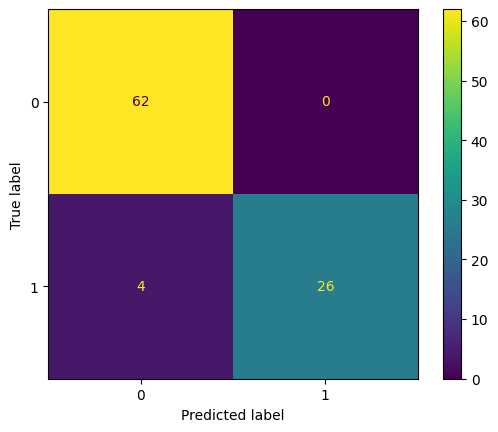

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=best_rf_classifier_model.classes_)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=best_rf_classifier_model.classes_
)
disp.plot()
plt.show()

Based on the confusion matrix, we were able to correctly predict 62 no outbreak weeks and none of the weeks were mistagged as an outbreak. Meanwhile, for the outbreak weeks we were only able to predict 26 out of those 30 weeks from the test set.

### 7.3 Visualize predicted probabilities


`predict_proba` calculates the probability estimates of each class produced by a model. It returns an array containing the probability (0.0 to 1.0) of a single record belonging to a particular class. The predicted probabilities can be visualized through a colored histogram of the values.


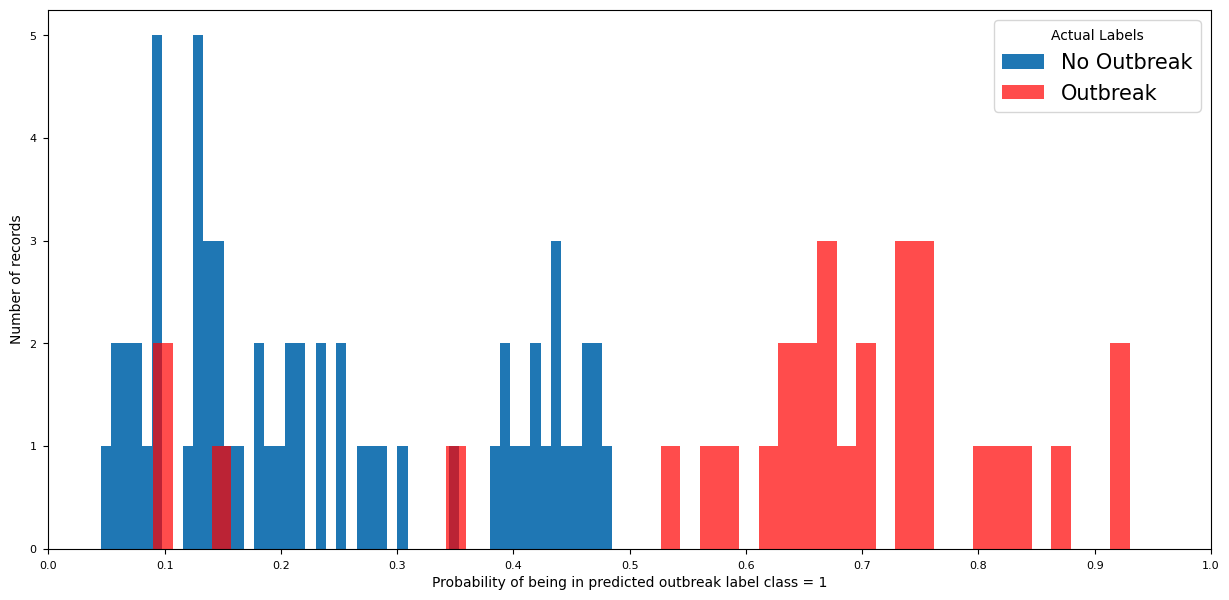

In [ ]:
prediction = y_pred_proba[:, 1]  # prediction for outbreak
plt.figure(figsize=(15, 7))
plt.hist(prediction[y_test == 0], bins=50, label="No Outbreak")
plt.hist(prediction[y_test == 1], bins=50, label="Outbreak", alpha=0.7, color="r")
plt.xlabel("Probability of being in predicted outbreak label class = 1", fontsize=10)
plt.ylabel("Number of records", fontsize=10)
plt.legend(fontsize=15, title="Actual Labels")
plt.tick_params(axis="both", labelsize=8, pad=5)
plt.xlim([0,1])
plt.xticks(np.arange(0,1.1,0.1))
plt.show()

In the plot above, the predicted probabilities are on the x-axis and the y-axis is the number of those instances. The colors are based on the actual labels. Most of the bars colored as blue are expected to lie on the left side *(probability < 0.5)* and the red bars on the right *(probability > 0.5)*. The distribution of values indicate that the model is sufficiently able to distinguish the presence of an outbreak based on the features we've given.

Furthermore, most of the outbreak weeks range from the 0.4 to 0.8 probabilities which indicates the model is able to confidently determine a week will become an outbreak, but there are still a few misdetections.

### 7.4. Identify features that best explains outbreak prediction

**SHAP (SHapley Additive exPlanations)** is a method used in machine learning for explaining individual predictions. It assigns each feature an importance value by considering its contribution to the difference between the actual prediction and the average prediction. Read up more on this method [here](https://shapash.readthedocs.io/en/latest/autodocs/shapash.explainer.html).

In [ ]:
xpl = SmartExplainer(
    model=best_rf_classifier_model
)
xpl.compile(x=X_test)

INFO: Shap explainer type - <shap.explainers._tree.TreeExplainer object at 0x7e237a6f3c10>


In [ ]:
xpl.plot.features_importance()


From SHAP, the features that drove the predictions are the cases from the previous weeks, the climate variables for temperature `tmax` and `tave`, and the mean population count.

## 8. Analyzing outbreak predictions

Prepare the dataframe to include the actual number of cases and predictions on one table.

In [ ]:
# Join back the predictions to the features for analysis.
analyze_df = X_test.copy()
#analyze_df["ADM3_PCODE"] = brgy_tests
analyze_df["case_total_dengue"] = numcases_test
analyze_df["actual_class"] = y_test
analyze_df["predicted_class"] = y_pred
analyze_df["predicted_proba_outbreak"] = y_pred_proba[:, 1]
analyze_df = analyze_df.reset_index()

In [ ]:
analyze_df.head()

,date,avg_rad_mean,clinic_count,clinic_nearest,dentist_count,dentist_nearest,doctors_count,doctors_nearest,heat_index,hospital_count,...,tmax,tmin,uv_rad,wind_speed,prev_3_wk_numcases,prev_1_mo_numcases,case_total_dengue,actual_class,predicted_class,predicted_proba_outbreak
0,2019-04-01,0.651854,0.0,10000.0,3.0,8206.760111,1.0,9160.802109,29.512940,50.0,...,28.704162,25.581742,32.469810,0.936903,70.0,45.0,61.0,0,0,0.095
1,2019-04-08,0.651854,0.0,10000.0,3.0,8206.760111,1.0,9160.802109,30.448520,50.0,...,28.901070,25.903043,30.584566,1.016081,58.0,70.0,53.0,0,0,0.155
2,2019-04-15,0.651854,0.0,10000.0,3.0,8206.760111,1.0,9160.802109,30.140211,50.0,...,28.764852,25.732192,31.826255,0.803671,57.0,58.0,64.0,0,0,0.090
3,2019-04-22,0.651854,0.0,10000.0,3.0,8206.760111,1.0,9160.802109,31.830942,50.0,...,29.596256,26.329052,32.588825,0.690626,61.0,57.0,82.0,1,0,0.105
4,2019-04-29,0.651854,0.0,10000.0,3.0,8206.760111,1.0,9160.802109,30.410928,50.0,...,28.936268,25.968195,30.016694,0.985122,53.0,61.0,90.0,1,0,0.090


### 8.1. Visualize Actual vs. Predicted Outbreak Periods



An **outbreak period** is defined as a span of consecutive weeks tagged as an outbreak (`outbreak=1`).

In the resulting table, there will be a `category` column indicating if it is the actual outbreak (came from the labeled dataset prior to model predictions) or a prediction outbreak.  

In [ ]:
# Define function to detect outbreak periods
def detect_outbreak_periods(tagged_df, target_class):
    """
    Args:
     tagged_df: dataframe that contains the outbreak tag
     target_class: class to summarize
    """
    # Create a boolean mask for rows with outbreak_tag = 1
    # tagged_df.sort_values(by=["ADM4_PCODE", "start_of_week"], inplace=True)
    tagged_df.sort_values(by=["date"], inplace=True)
    outbreak_mask = tagged_df[target_class] == 1

    # Calculate a group ID for each consecutive outbreak period within the same barangay
    outbreak_groups = (outbreak_mask != outbreak_mask.shift(fill_value=False)).cumsum()
    # Add the 'outbreak_groups' column to the DataFrame
    tagged_df["outbreak_group"] = outbreak_groups
    # Filter rows with outbreak_tag = 1
    outbreak_df = tagged_df[outbreak_mask]
    # Group by 'barangay' and 'outbreak_group' and calculate start date, end date, and length
    outbreak_summary = (
        outbreak_df.groupby(["outbreak_group"])  # adm4_pcode
        .agg(
            start_date=("date", "min"),
            end_date=("date", "max"),
            actual_length_weeks=(target_class, "count"),
        )
        .reset_index()
    )
    return outbreak_summary

In [ ]:
actual_outbreaks_summary = detect_outbreak_periods(analyze_df, "actual_class")
actual_outbreaks_summary["category"] = "actual"
predicted_outbreaks_summary = detect_outbreak_periods(analyze_df, "predicted_class")
predicted_outbreaks_summary["category"] = "predicted"

outbreak_lengths_results = pd.concat(
    [actual_outbreaks_summary, predicted_outbreaks_summary]
)
outbreak_lengths_results

,outbreak_group,start_date,end_date,actual_length_weeks,category
0,1,2019-04-22,2019-11-11,30,actual
0,1,2019-05-20,2019-11-11,26,predicted


Running the cell below should produce a dumbbell plot that compares the actual outbreak periods from the predicted outbreak periods.

In [ ]:
# Set custom colors
class_colors = {"predicted": "#53bed0", "actual": "#ff5733"}

# Plot start and end outbreak points
fig = px.scatter(
    outbreak_lengths_results,
    x=["start_date", "end_date"],
    y="category",
    color="category",
    size="actual_length_weeks",
    labels={"x": "Date"},
    category_orders={"category": ["actual", "predicted"]},
    color_discrete_map=class_colors,
)

for i, row in outbreak_lengths_results.iterrows():
    fig.add_trace(
        go.Scatter(
            mode="lines",
            # layer="below",
            line=dict(
                color=class_colors[row["category"]],
                width=3,
                dash="solid",
            ),
            # connect the two markers
            x=[row["start_date"], row["end_date"]],
            y=[row["category"], row["category"]],
            showlegend=False,
        )
    )

# Update layout with title and axis titles
fig.update_layout(
    title="Dengue Outbreak Periods for Zamboanga City, Apr 2019 - Dec 2020",
    xaxis_title="Date",
    yaxis_title="Category",
)
fig.show()


The resulting plot should look similar to this. The plot shows the outbreak periods from the dataframe prepared above. <br> <br>
<img src="https://raw.githubusercontent.com/thinkingmachines/project-cchain/gh-pages/assets/dengue_outbreak_periods_sample_result.png" width="90%">

Based on actual data, there is only one outbreak period for the target timespan, a 30-week event from 2019-04-22 to 2019-11-11. The model predicted a 26-week outbreak period from 2019-05-20	to 2019-11-11, which was detected 4 weeks after actual, and ended on the same week.

While most of the outbreak period was covered, the model still needs to be trained to be more sensitive to the start of the outbreak, which is crucial for early intervention.

### 8.2. Visualize actual Number of Cases with Predicted label
Run the cell below to plot the actual number of cases as a histogram, with bars during weeks where model detected an outbreak are marked in a different color.

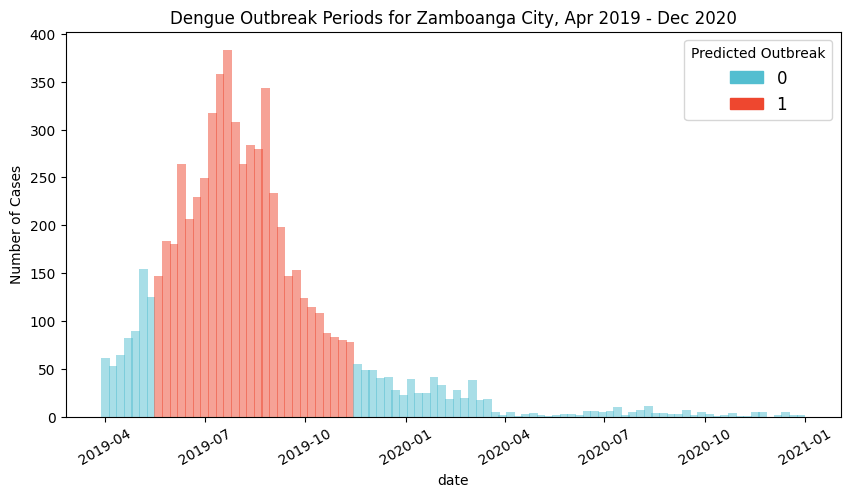

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

# Define colors for each class
class_colors = {0: "#53bed0", 1: "#ee472f"}

# Plot the bar plot
ax.bar(
    analyze_df["date"],
    analyze_df["case_total_dengue"],
    alpha=0.5,
    label="Bar Plot",
    width=8,
    color=[class_colors[c] for c in analyze_df["predicted_class"]],
)

# Rotate x-axis labels
plt.xticks(rotation=30)

# Create legend handles and labels for bar plot
legend_handles = [
    plt.Rectangle((0, 0), 1, 1, color=color) for color in class_colors.values()
]
legend_labels = list(class_colors.keys())

# Add legend for bar plot
ax.legend(legend_handles, legend_labels, fontsize="large", title="Predicted Outbreak")
# Add title and axis labels
ax.set_title("Dengue Outbreak Periods for Zamboanga City, Apr 2019 - Dec 2020")
ax.set_xlabel("date")
ax.set_ylabel("Number of Cases")
plt.show()


The resulting plot should look similar to this <br> <br>
<img src="https://raw.githubusercontent.com/thinkingmachines/project-cchain/gh-pages/assets/dengue_outbreak_num_cases_sample_result.png" width="90%">

The model was able to determine outbreaks for the consectuve weeks in 2019-05-20 to 2019-11-11, when actual data records  75-380 weekly cases.

For the rest of 2020, it was also able to correctly identify that there should be no outbreaks during that year.


### 8.3 Analyze predicted probabilities if aligned with when cases peaked

Lastly, plot the probabilities of `outbreak=1` along with the actual number of cases through a time series plot.

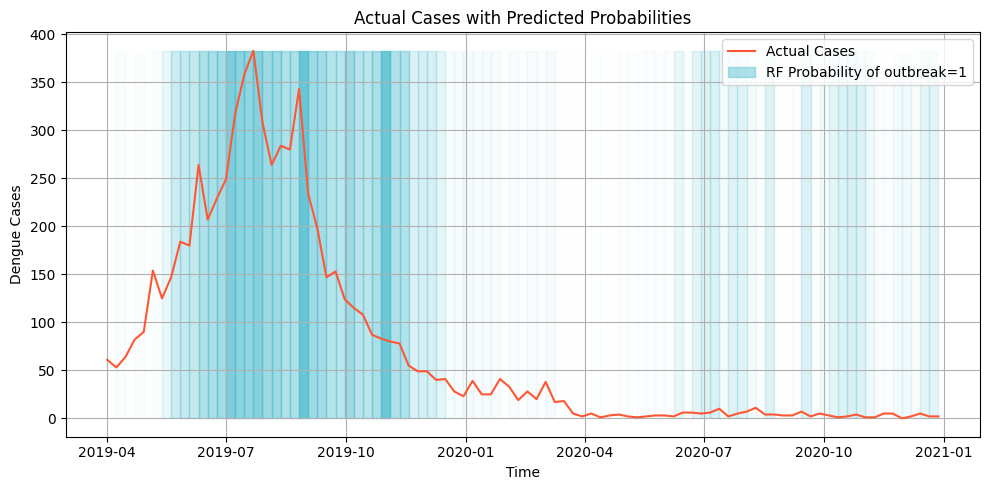

In [ ]:
plt.figure(figsize=(10, 5))

# Plotting the line plot for actual cases with a different color
plt.plot(
    analyze_df["date"],
    analyze_df["case_total_dengue"],
    color="#ff5733",  # Reddish color for better visibility
    label="Actual Cases",
)

# Define your own gradient color
gradient_color = "#53bed0"  # Blueish color for the gradient

# Define the number of points for the gradient
num_points = len(analyze_df)

# Create a custom colormap with the gradient color
colors = [(0, gradient_color), (1, gradient_color)]
cmap = LinearSegmentedColormap.from_list("custom_gradient", colors)

# Creating a background gradient for predicted probabilities
for i in range(len(analyze_df) - 1):
    start_date = analyze_df["date"].iloc[i]
    end_date = analyze_df["date"].iloc[i + 1]
    alpha = np.power(analyze_df["predicted_proba_outbreak"].iloc[i],2)  # Use scaled predicted probability as alpha
    plt.fill_between(
        analyze_df["date"],  # x-values (dates)
        analyze_df["case_total_dengue"].min(),  # Bottom y-value (minimum of actual cases)
        analyze_df["case_total_dengue"].max(),  # Top y-value (maximum of actual cases)
        where=(
            (analyze_df["date"] >= start_date) & (analyze_df["date"] <= end_date)
        ),  # Condition for filling the area
        color=cmap(i / num_points),  # Use colormap to set gradient color
        alpha=alpha,  # Set alpha based on predicted probability
        label="RF Probability of outbreak=1"
        if i == 10
        else None,  # Include legend only for the first fill_between
    )

# Add legend for the line plot and the gradient
plt.legend()

# Setting labels and title
plt.xlabel("Time")
plt.ylabel("Dengue Cases")
plt.title("Actual Cases with Predicted Probabilities")

# Displaying the plot
plt.grid(True)
plt.tight_layout()
plt.show()


The resulting plot should look similar to this <br> <br>
<img src="https://raw.githubusercontent.com/thinkingmachines/project-cchain/gh-pages/assets/dengue_outbreak_periods_probability_sample_result.png" width="90%">

In this plot, the line plot represents the number of cases over time and the gradient in the background represents the predicted probablity of an outbreak for that week. The darker the color the more likely it is to be classified as an outbreak.

Weeks with sudden spikes are able to identified by the model as an outbreak along with the succeeding high weeks. It can also be seen in the plot that even during the low number of cases in 2020, the model is able to predict slightly higher probability for the weeks with sudden spikes. This can indicate some potential in using the probabilities as a signal for preparations for early intervention.


## Recommendations

Consider the following when trying to explore modelling with our dataset
1.  Pick another classifier model, such as other tree-based models like [XGBoost](https://xgboost.readthedocs.io/en/stable/tutorials/model.html), or one with a different prediction mechanic, such as [kNN](https://www.analyticsvidhya.com/blog/2018/03/introduction-k-neighbours-algorithm-clustering/). These may potentially enhance model accuracy and robustness.
2. Experiment more with feature engineering by selecting variables with more resolved temporal scales, such as climate variables, by analyzing statistics over weekly intervals rather than just mean values.
3. Validate the model's applicability across diverse scenarios by testing it on data from another city or disease, acknowledging potential variations in performance while emphasizing the generalizability of the methodology.

For inquiries on this model, contact the developers at [lacuna-fund-project-team@thinkingmachin.es](lacuna-fund-project-team@thinkingmachin.es)